# Probabilistic Forecasting: Global Models

Skforecast allows to apply all its implemented probabilistic forecasting methods (bootstrapping, conformal prediction and quantile regression) to global models. This means that the model is trained with all the available time series and the forecast is made for all the time series.

For detailed information about the available probabilistic forecasting methods, see the following user guides:

- [Probabilistic forecasting: Bootstrapping](../user_guides/probabilistic-forecasting-bootstrapped-residuals.html)

- [Probabilistic forecasting: Conformal prediction](../user_guides/probabilistic-forecasting-conformal-prediction.html)

- [Probabilistic forecasting: Quantile regression](../user_guides/probabilistic-forecasting-quantile-regression.html)

- [Probabilistic forecasting: Calibrate intervals](../user_guides/probabilistic-forecasting-calibrate-intervals.html)

## Libraries and data

In [ ]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
from skforecast.plot import plot_prediction_intervals
from statsmodels.graphics.tsaplots import plot_pacf
from itertools import cycle

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.metrics import calculate_coverage
from skforecast.plot import calculate_lag_autocorrelation
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [249]:
# Data
# ==============================================================================
#data_all = pd.read_parquet('../../dev/bdg2_hourly.parquet')
ids = ['Hog_health_Hisako', 'Hog_health_Kesha', 'Mouse_health_Estela']
data = data_all[data_all['building_id'].isin(ids)].copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.pivot_table(index='timestamp', columns='building_id', values='meter_reading')
data = data.asfreq('h')
data = data.loc[:'2017-09-30'].copy()
data = data.interpolate(method='linear')
data.columns = [f"building_{i+1}" for i in range(data.shape[1])]
data['building_1'] = np.where(data['building_1'] < 150, np.nan, data['building_1'])
data['building_2'] = np.where(data['building_2'] < 150, np.nan, data['building_2'])
data['building_3'] = np.where(data['building_3'] < 200, np.nan, data['building_3'])
data = data.interpolate(method='linear')
data = data.resample('4h').sum()
data

,building_1,building_2,building_3
timestamp,,,
2016-01-01 00:00:00,740.846,876.891,813.0
2016-01-01 04:00:00,736.495,883.747,1129.0
2016-01-01 08:00:00,752.319,912.541,1221.0
2016-01-01 12:00:00,751.190,909.865,1243.0
2016-01-01 16:00:00,747.692,896.963,1264.0
...,...,...,...
2017-09-30 04:00:00,701.271,880.064,1073.0
2017-09-30 08:00:00,753.960,891.246,1290.0
2017-09-30 12:00:00,783.731,907.218,1395.0


In [250]:
# Data
# ==============================================================================
# data = fetch_dataset(name="bdg2_hourly_sample")
# data = data.interpolate(method='linear')
# data = data.loc['2017-01-01':'2017-09-30']
# data.head(2)

In [251]:
# Calendar features
# ==============================================================================
data['day_of_week'] = data.index.dayofweek
data['hour'] = data.index.hour

transformer = ColumnTransformer(
    transformers=[
        ('onehotencoder', OneHotEncoder(sparse_output=False), ['day_of_week', 'hour'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
).set_output(transform='pandas')
data = transformer.fit_transform(data)

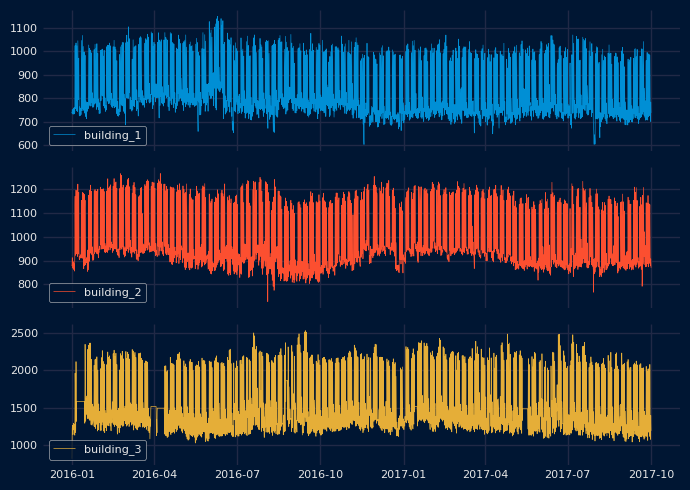

In [252]:
# Plot time series
# ==============================================================================
set_dark_theme()
plt.rcParams['lines.linewidth'] = 0.5
colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
series = ['building_1', 'building_2', 'building_3']
for i, col in enumerate(series):
    axs[i].plot(data[col], label=col, color=next(colors))
    axs[i].legend(loc='lower left', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

plt.tight_layout()

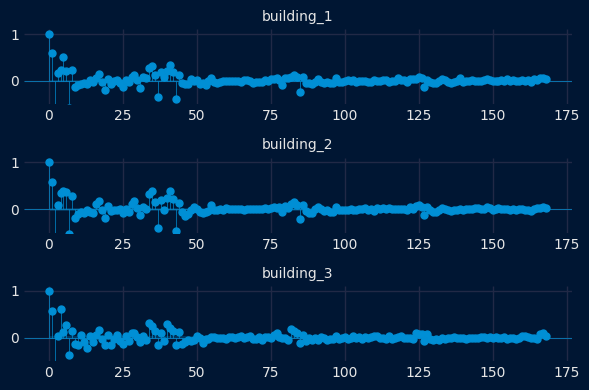

In [253]:
# Partial autocorrelation values and plots
# ==============================================================================
n_lags = 24*7
pacf_df = []

fig, axs = plt.subplots(3, 1, figsize=(6, 4))
axs = axs.ravel()
for i, col in enumerate(series):
    pacf_values = calculate_lag_autocorrelation(data[col], n_lags=n_lags)
    pacf_values['variable'] = col
    pacf_df.append(pacf_values)
    
    plot_pacf(data[col], lags=n_lags, ax=axs[i])
    axs[i].set_title(col, fontsize=10)
    axs[i].set_ylim(-0.5, 1.1)

plt.tight_layout()

In [254]:
# Top n lags with highest absolute partial autocorrelation per variable
# ==============================================================================
n = 10
top_lags = set()
for pacf_values in pacf_df:
    variable = pacf_values['variable'].iloc[0]
    lags = pacf_values.nlargest(n, 'partial_autocorrelation_abs')['lag'].sort_values().tolist()
    top_lags.update(lags)
    print(f"{variable}: {lags}")

top_lags = list(top_lags)
top_lags.sort()
print(f"\nAll lags: {top_lags}")

building_1: [1, 2, 5, 7, 34, 35, 37, 41, 43, 85]
building_2: [1, 2, 4, 5, 6, 7, 35, 37, 41, 43]
building_3: [1, 2, 4, 6, 7, 13, 34, 35, 40, 41]

All lags: [1, 2, 4, 5, 6, 7, 13, 34, 35, 37, 40, 41, 43, 85]


The target series exhibit similar dynamics with several lagged correlations that can be used as predictors.

In [274]:
# Split train-validation-test
# ==============================================================================
end_train = '2017-05-15 23:59:00'
end_validation = '2017-09-15 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2016-01-01 00:00:00 --- 2017-05-15 20:00:00  (n=3006)
Dates validacion : 2017-05-16 00:00:00 --- 2017-09-15 20:00:00  (n=738)
Dates test       : 2017-09-16 00:00:00 --- 2017-09-30 20:00:00  (n=90)


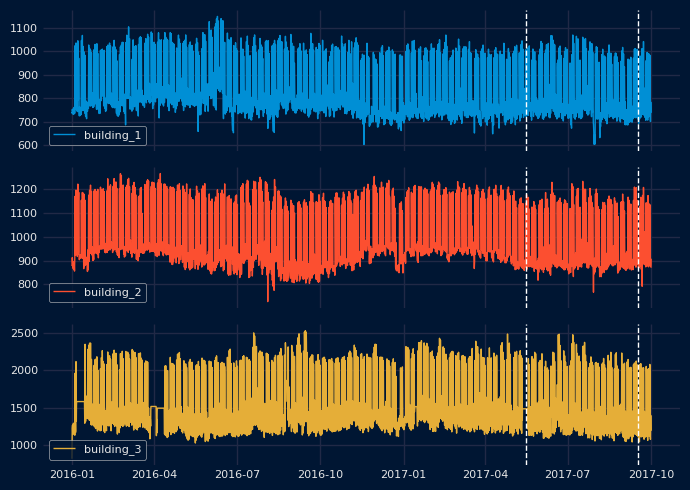

In [275]:
# Plot partitions
# ==============================================================================
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
for i, col in enumerate(series):
    axs[i].plot(data[col], label=col, color=colors[i])
    axs[i].legend(loc='lower left', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)
    axs[i].axvline(pd.to_datetime(end_train), color='white', linestyle='--', linewidth=1)  # End train
    axs[i].axvline(pd.to_datetime(end_validation), color='white', linestyle='--', linewidth=1)  # End validation

plt.tight_layout()

In [276]:
# Create forecaster
# ==============================================================================
exog_features = data.columns[data.columns.str.contains('day_of_|hour_')].tolist()

params = {
    "n_estimators": 300,
    "learning_rate": 0.1,
    "max_depth": 5,
    'linear_tree': True
}
window_features = RollingFeatures(stats=["mean", "min", "max"], window_sizes=24)
forecaster = ForecasterRecursiveMultiSeries(
                 regressor       = LGBMRegressor(random_state=15926, verbose=-1, **params),
                 lags            = top_lags,
                 window_features = window_features,
                 encoding        = 'ordinal',
                 binner_kwargs   = {'n_bins': 5},
             )

In [277]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         initial_train_size = len(data.loc[:end_train, :]),
         steps              = 8,
     )

metric_val, predictions_val = backtesting_forecaster_multiseries(
                                  forecaster    = forecaster,
                                  series        = data.loc[:end_validation, series],
                                  exog          = data.loc[:end_validation, exog_features],
                                  cv            = cv,
                                  metric        = 'mean_absolute_error',
                                  n_jobs        = 'auto',
                                  verbose       = False,
                                  show_progress = True
                              )

  0%|          | 0/93 [00:00<?, ?it/s]

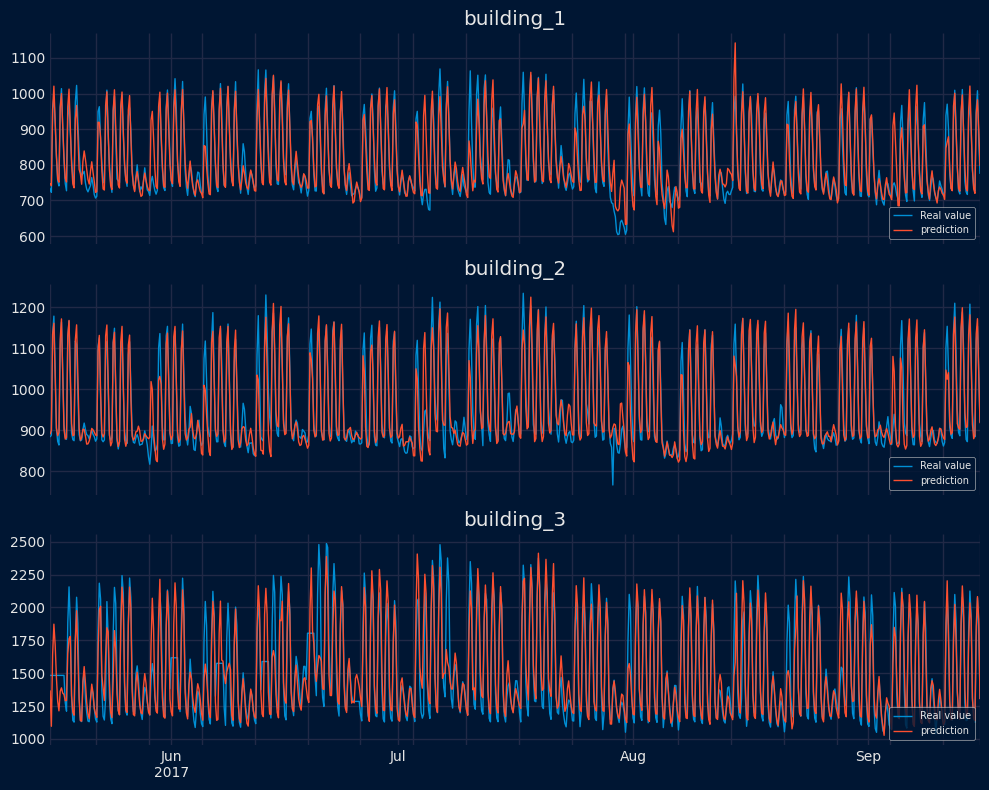

In [278]:
# Plot predictions on validation data
# ==============================================================================
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=False)
for i, level in enumerate(predictions_val['level'].unique()):
    predictions_val_level = predictions_val.loc[predictions_val['level'] == level, 'pred']
    data.loc[end_train:end_validation, level].plot(ax=axs[i], label='Real value')
    predictions_val_level.plot(ax=axs[i], label='prediction')
    axs[i].set_xlabel("")
    axs[i].set_title(level)
    axs[i].legend(loc='lower right', fontsize=7)

plt.tight_layout()

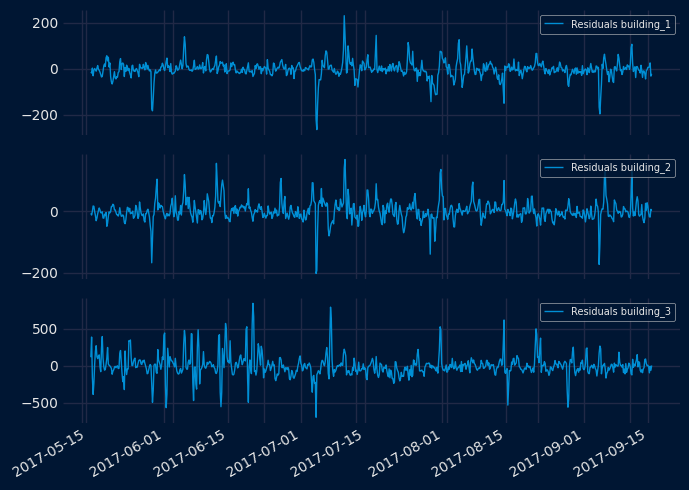

In [279]:
# Out-sample residuals distribution
# ==============================================================================
fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True, sharey=False)
for i, level in enumerate(predictions_val["level"].unique()):
    residuals = (
        data.loc[predictions_val.index, level]
        - predictions_val.loc[predictions_val["level"] == level, "pred"]
    )
    residuals.plot(ax=axs[i], label=f"Residuals {level}")
    axs[i].legend(loc="upper right", fontsize=7)

fig.tight_layout()

In [280]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.fit(
    series = data.loc[:end_train, series],
    exog   = data.loc[:end_train, exog_features]
)
forecaster.set_out_sample_residuals(
    y_true = {k: data.loc[predictions_val.index.unique(), k] for k in series}, 
    y_pred = {k: v for k, v in predictions_val.groupby('level')['pred']}
)

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

When new residuals are stored in the forecaster, the residuals are binned according to the size of the predictions to which they correspond. Later, in the bootstrapping process, the residuals are sampled from the appropriate bin to ensure that the distribution of the residuals is consistent with the predictions. This process allows for more accurate prediction intervals because the residuals are more closely aligned with the predictions to which they correspond, resulting in better coverage with narrower intervals. For more information about how residuals are used in interval estimation visit <a href="../user_guides/probabilistic-forecasting.html">Probabilistic forecasting: prediction intervals and prediction distribution</a>.

</div>

In [281]:
# Intervals of the residual bins (conditioned on predicted values) for each level
# ==============================================================================
from pprint import pprint

for k, v in forecaster.binner_intervals_.items():
    print(k)
    pprint(v)
    print("")

building_1
{0: (627.3237074098435, 744.0570234203923),
 1: (744.0570234203923, 778.735900012309),
 2: (778.735900012309, 829.0426924900677),
 3: (829.0426924900677, 951.9980472176521),
 4: (951.9980472176521, 1140.1637975099645)}

building_2
{0: (797.1366863188777, 895.9129384089999),
 1: (895.9129384089999, 932.9680478956521),
 2: (932.9680478956521, 959.7501085843395),
 3: (959.7501085843395, 1123.5657848523647),
 4: (1123.5657848523647, 1248.1518077600565)}

building_3
{0: (1044.215675149448, 1237.3962517333532),
 1: (1237.3962517333532, 1348.3806399967898),
 2: (1348.3806399967898, 1494.5223973348707),
 3: (1494.5223973348707, 1959.2004607339088),
 4: (1959.2004607339088, 2510.3799093429993)}

_unknown_level
{0: (1044.215675149448, 1237.3962517333532),
 1: (1237.3962517333532, 1348.3806399967898),
 2: (1348.3806399967898, 1494.5223973348707),
 3: (1494.5223973348707, 1959.2004607339088),
 4: (1959.2004607339088, 2510.3799093429993)}



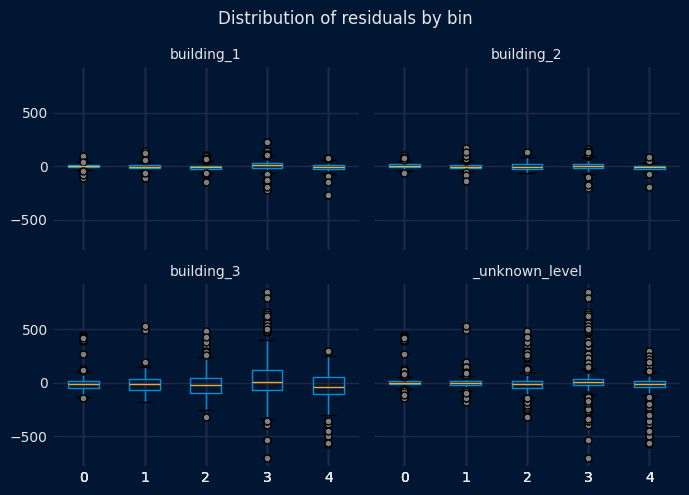

In [282]:
# Distribution of the residual by bin and level
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(7, 5), sharex=True, sharey=True)
axs = axs.ravel()
for i, level in enumerate(forecaster.out_sample_residuals_by_bin_):
    out_sample_residuals_by_bin_df = pd.DataFrame(
        dict(
            [(k, pd.Series(v))
            for k, v in forecaster.out_sample_residuals_by_bin_[level].items()]
        )
    )
    flierprops = dict(marker='o', markerfacecolor='gray', markersize=5, linestyle='none')
    out_sample_residuals_by_bin_df.boxplot(ax=axs[i], flierprops=flierprops)
    axs[i].set_title(level, fontsize=10)

fig.suptitle("Distribution of residuals by bin", fontsize=12)
fig.tight_layout()

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Two arguments control the use of residuals in `predict()` and `backtesting_forecaster()`:

+ `use_in_sample_residuals`: If `True`, the in-sample residuals are used to compute the prediction intervals. Since these residuals are obtained from the training set, they are always available, but usually lead to overoptimistic intervals. If `False`, the out-sample residuals (calibration) are used to calculate the prediction intervals. These residuals are obtained from the validation/calibration set and are only available if the `set_out_sample_residuals()` method has been called. It is recommended to use out-sample residuals to achieve the desired coverage.

+ `use_binned_residuals`: If `False`, a single correction factor is applied to all predictions during conformalization. If `True`, the conformalization process uses a correction factor that depends on the bin where the prediction falls. This can be thought as a type of <b>Adaptive Conformal Predictions</b> and it can lead to more accurate prediction intervals since the correction factor is conditioned on the region of the prediction space.

</div>

## Intervals using conformal prediction

In [283]:
# Backtesting with conformal prediction intervals
# ==============================================================================
cv = TimeSeriesFold(
         initial_train_size = len(data.loc[:end_validation, :]),
         steps              = 8,
     )

metric, predictions_test = backtesting_forecaster_multiseries(
                                forecaster              = forecaster,
                                series                  = data[series],
                                exog                    = data[exog_features],
                                cv                      = cv,
                                metric                  = 'mean_absolute_error',
                                interval                = [10, 90],
                                interval_method         = "conformal",
                                use_in_sample_residuals = False,  # Use out-sample residuals
                                use_binned_residuals    = True,   # Adaptative intervals
                                n_jobs                  = 'auto',
                                verbose                 = False,
                                show_progress           = True
                            )
predictions_test

  0%|          | 0/12 [00:00<?, ?it/s]

,level,pred,lower_bound,upper_bound
2017-09-16 00:00:00,building_1,729.305744,707.986259,750.625229
2017-09-16 00:00:00,building_2,890.319807,857.958291,922.681324
2017-09-16 00:00:00,building_3,1156.042114,1089.245489,1222.838739
2017-09-16 04:00:00,building_1,710.485284,689.165799,731.804769
2017-09-16 04:00:00,building_2,884.689087,860.418902,908.959271
...,...,...,...,...
2017-09-30 16:00:00,building_2,907.867154,875.505637,940.228670
2017-09-30 16:00:00,building_3,1330.037588,1229.980127,1430.095050
2017-09-30 20:00:00,building_1,726.079811,704.760326,747.399296
2017-09-30 20:00:00,building_2,886.753017,862.482832,911.023201



Level: building_1
Predicted interval coverage: 97.78 %
Area of the interval: 5847.52

Level: building_2
Predicted interval coverage: 74.44 %
Area of the interval: 6273.67

Level: building_3
Predicted interval coverage: 93.33 %
Area of the interval: 23838.99


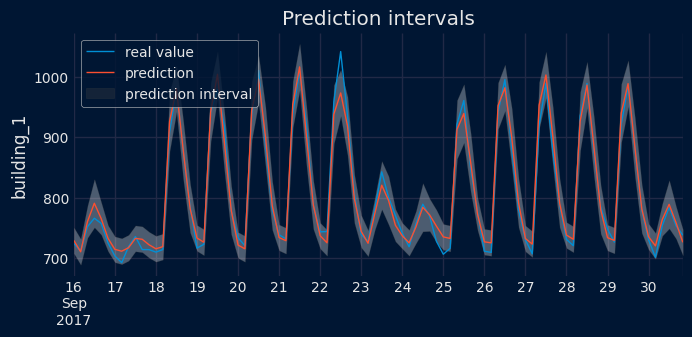

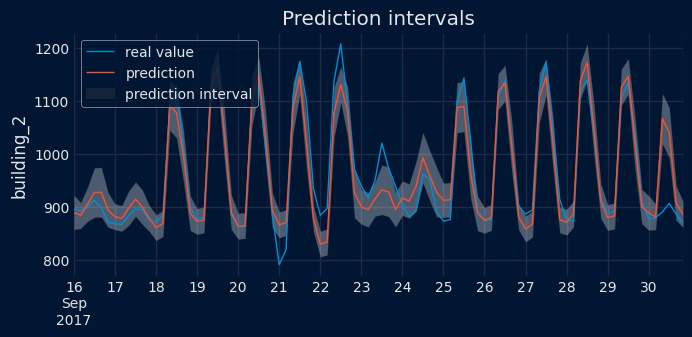

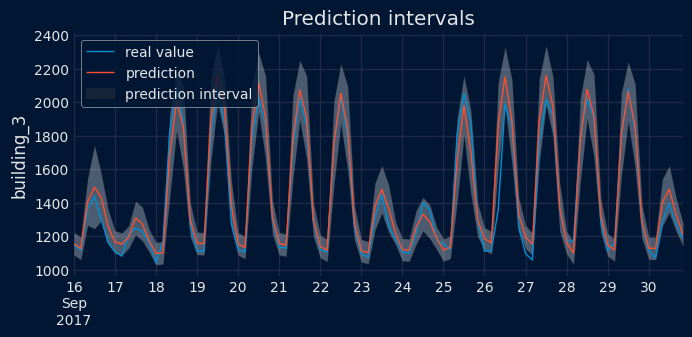

In [284]:
# Plot intervals and calculate coverage for each level
# ==============================================================================
for level in predictions_test['level'].unique():
    print(f"\nLevel: {level}")
    predictions_level = predictions_test[predictions_test['level'] == level].drop(columns='level').copy()
    
    # Plot intervals
    plt.rcParams['lines.linewidth'] = 1
    fig, ax = plt.subplots(figsize=(7, 3))
    plot_prediction_intervals(
        predictions     = predictions_level,
        y_true          = data_test[[level]],
        target_variable = level,
        initial_x_zoom  = None,
        title           = "Prediction intervals",
        xaxis_title     = "",
        yaxis_title     = level,
        ax              = ax
    )
    plt.gca().legend(loc='upper left')
    fill_between_obj = ax.collections[0]
    fill_between_obj.set_facecolor('white')
    fill_between_obj.set_alpha(0.3)

    # Predicted interval coverage (on test data)
    coverage = calculate_coverage(
                   y_true      = data_test[level],
                   lower_bound = predictions_level["lower_bound"], 
                   upper_bound = predictions_level["upper_bound"]
               )
    print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

    # Area of the interval
    area = (predictions_level["upper_bound"] - predictions_level["lower_bound"]).sum()
    print(f"Area of the interval: {round(area, 2)}")

## Intervals using bootstrapped residuals

The same process is repeated but this time using the conformal method instead of bootstrapping.

In [285]:
# Backtesting with prediction intervals using bootstrapping
# ==============================================================================
cv = TimeSeriesFold(
         initial_train_size = len(data.loc[:end_validation, :]),
         steps              = 8,  # all hours of next day
     )

metric, predictions_test = backtesting_forecaster_multiseries(
                                forecaster              = forecaster,
                                series                  = data[series],
                                exog                    = data[exog_features],
                                cv                      = cv,
                                metric                  = 'mean_absolute_error',
                                interval                = [10, 90],
                                interval_method         = "bootstrapping",
                                n_boot                  = 150,
                                use_in_sample_residuals = False,  # Use out-sample residuals
                                use_binned_residuals    = True,   # Residuals conditioned on predicted values
                                n_jobs                  = 'auto',
                                verbose                 = False,
                                show_progress           = True
                            )
predictions_test

  0%|          | 0/12 [00:00<?, ?it/s]

,level,pred,lower_bound,upper_bound
2017-09-16 00:00:00,building_1,729.305744,711.904454,754.290369
2017-09-16 00:00:00,building_2,890.319807,866.175556,935.724462
2017-09-16 00:00:00,building_3,1156.042114,1093.496508,1237.444164
2017-09-16 04:00:00,building_1,710.485284,677.529317,738.293254
2017-09-16 04:00:00,building_2,884.689087,853.496154,933.331802
...,...,...,...,...
2017-09-30 16:00:00,building_2,907.867154,872.771196,935.533083
2017-09-30 16:00:00,building_3,1330.037588,1207.350633,1439.097417
2017-09-30 20:00:00,building_1,726.079811,684.599440,741.667347
2017-09-30 20:00:00,building_2,886.753017,851.365669,922.545373



Level: building_1
Predicted interval coverage: 98.89 %
Area of the interval: 9518.37

Level: building_2
Predicted interval coverage: 90.0 %
Area of the interval: 8707.93

Level: building_3
Predicted interval coverage: 95.56 %
Area of the interval: 38874.17


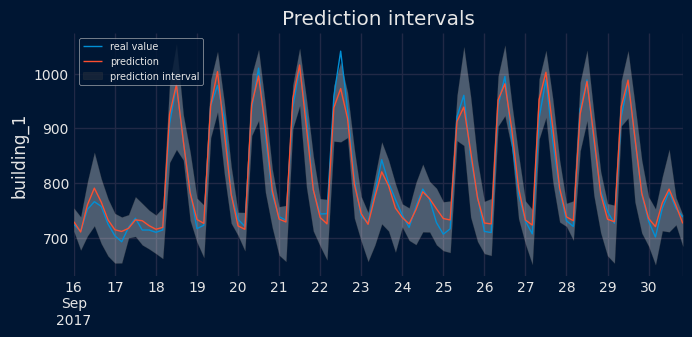

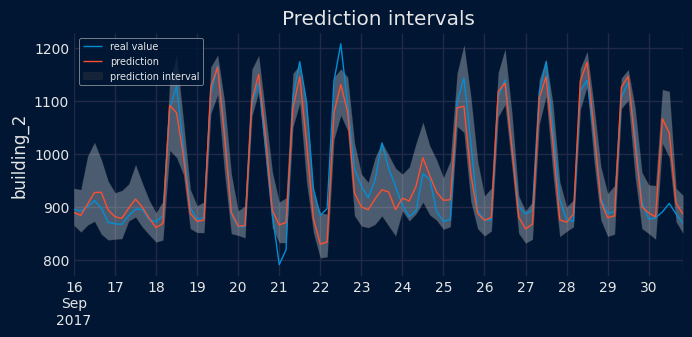

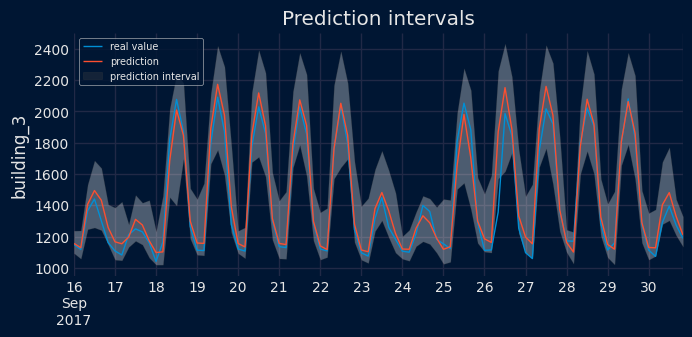

In [286]:
# Plot intervals and calculate coverage for each level
# ==============================================================================
for level in predictions_test["level"].unique():
    print(f"\nLevel: {level}")
    predictions_level = (
        predictions_test[predictions_test["level"] == level]
        .drop(columns="level")
        .copy()
    )

    # Plot intervals
    plt.rcParams["lines.linewidth"] = 1
    fig, ax = plt.subplots(figsize=(7, 3))
    plot_prediction_intervals(
        predictions=predictions_level,
        y_true=data_test[[level]],
        target_variable=level,
        initial_x_zoom=None,
        title="Prediction intervals",
        xaxis_title="",
        yaxis_title=level,
        ax=ax,
    )
    plt.gca().legend(loc="upper left", fontsize=7)
    fill_between_obj = ax.collections[0]
    fill_between_obj.set_facecolor("white")
    fill_between_obj.set_alpha(0.3)

    # Predicted interval coverage (on test data)
    coverage = calculate_coverage(
        y_true=data_test[level],
        lower_bound=predictions_level["lower_bound"],
        upper_bound=predictions_level["upper_bound"],
    )
    print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

    # Area of the interval
    area = (predictions_level["upper_bound"] - predictions_level["lower_bound"]).sum()
    print(f"Area of the interval: {round(area, 2)}")

The resulting intervals are overly conservative, they have an empirical coverage higher than expected (80%).

## Forescasting intervals for unknown series

The `ForecasterRecursiveMultiseries` class allows the forecasting of series not seen during training, with the only requirement that at least `window_size` observations of the new series are available. To generate probabilistic predictions, the forecaster uses a random sample of the residuals of all known series.

In [287]:
# Predictions for an known series
# ==============================================================================
# Simulate last_window of the new series
last_window = pd.DataFrame({
    'new_series': data_val['building_1'].iloc[-165:] + np.random.normal(0, 0.1, 165)
})

forecaster.predict_interval(
    steps       = 10,
    last_window = last_window,
    exog        = data_test[exog_features],
    interval    = [10, 90],
    n_boot      = 150,
)

╭──────────────────────────────── UnknownLevelWarning ─────────────────────────────────╮
│ `levels` {'new_series'} were not included in training. Unknown levels are encoded as │
│ NaN, which may cause the prediction to fail if the regressor does not accept NaN     │
│ values.                                                                              │
│                                                                                      │
│ Category : UnknownLevelWarning                                                       │
│ Location :                                                                           │
│ /home/ubuntu/anaconda3/envs/skforecast_15_py12/lib/python3.12/site-packages/skforeca │
│ st/utils/utils.py:899                                                                │
│ Suppress : warnings.simplefilter('ignore', category=UnknownLevelWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────── UnknownLevelWarning ─────────────────────────────────╮
│ `levels` {'new_series'} are not present in `forecaster.in_sample_residuals_`, most   │
│ likely because they were not present in the training data. A random sample of the    │
│ residuals from other levels will be used. This can lead to inaccurate intervals for  │
│ the unknown levels.                                                                  │
│                                                                                      │
│ Category : UnknownLevelWarning                                                       │
│ Location :                                                                           │
│ /home/ubuntu/anaconda3/envs/skforecast_15_py12/lib/python3.12/site-packages/skforeca │
│ st/utils/utils.py:1282                                                               │
│ Suppress : warnings.simplefilter('ignore', category=UnknownLevelWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

,level,pred,lower_bound,upper_bound
2017-09-16 00:00:00,new_series,728.066345,703.329323,753.729078
2017-09-16 04:00:00,new_series,704.535816,667.862682,741.075502
2017-09-16 08:00:00,new_series,763.774606,718.876321,814.055689
2017-09-16 12:00:00,new_series,793.981067,754.256443,848.048861
2017-09-16 16:00:00,new_series,762.157156,735.147793,812.551898
2017-09-16 20:00:00,new_series,730.965212,696.710271,776.846891
2017-09-17 00:00:00,new_series,713.435240,676.257640,761.629996
2017-09-17 04:00:00,new_series,707.680374,667.210243,762.690049
2017-09-17 08:00:00,new_series,727.283407,656.415895,810.768775
2017-09-17 12:00:00,new_series,759.441957,698.152425,828.487388


## Probabilistic forecasting in production

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff9100;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

<p>

The correct estimation of prediction intervals with conformal methods depends on the residuals being representative of future errors. For this reason, calibration residuals should be used. However, the dynamics of the series and models can change over time, so it is important to monitor and regularly update the residuals. It can be done easily using the <code>set_out_sample_residuals()</code> method.
</p>

</div>